# Подключение к Postgres

In [4]:
import datetime
import logging
import os
from subprocess import call

import numpy as np

import pandas as pd
from sqlalchemy import create_engine


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# движок нужен для подключения к Postgres
engine = create_engine(
    'postgresql://postgres:@{}:{}'.format('postgres_host',5432)
)

In [10]:
sql_query = """
    SELECT
        to_char(to_timestamp(rocket_datetime),'YYYY-MM-DD') dt,
        COUNT(*) as page_impression_count
    FROM movie.events
    WHERE
        name = 'page_impression'
    GROUP BY dt
"""

In [11]:
event_count = pd.read_sql(
    sql=sql_query,
    con=engine
)

In [14]:
event_count

,dt,page_impression_count
0,2019-06-01,3191
1,2019-06-02,5245
2,2019-06-03,4558
3,2019-06-04,5248
4,2019-06-05,4740
...,...,...
87,2019-08-27,19855
88,2019-08-28,20725
89,2019-08-29,20370
90,2019-08-30,20984


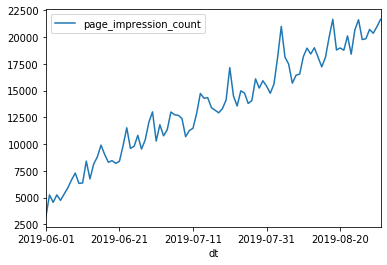

In [15]:
event_count.plot(x='dt', y='page_impression_count')

Базовый класс для чтения из Postrgres в Pandas DataFrame.

In [7]:
class PosgresConnector():
    """Класс для чтения данных из Postgres Spark DataFrame"""
    _sql = None  # type: Optional[str]
    _df_schema = None  # type: Optional[str]

    def __init__(self, engine):
        self.engine = engine

    def load_df(self, **kwargs) -> pd.DataFrame:
        """Трансформация sql-запроса в Spark DataFrame

        :return: датафрейм PySpark
        """
        if self._sql is None:
            raise ValueError('Не задан SQL скрипт')
        elif self._df_schema is None:
            raise ValueError('Не задана типизация колонок pandas DataFrame')
        else:
            sql = self._sql.format(**kwargs)
            logger.info('Выгрузка %s: поля %s' % (self.__class__.__name__, self._df_schema))
            # основная 
            return pd.read_sql(sql, self.engine).head()

Создаём класс-наследник с SQL для чтения оценов.

SQL параметризован параметром `USER_ID`

In [10]:
class UserRatingsView(PosgresConnector):
    _sql = """
        SELECT userId, movieId
        FROM ratings
        WHERE
            userId = {USER_ID}
    """

    _df_schema = ['userid', 'movieid']
    
user_ratings = RatingView(engine).load_df(USER_ID=1)

2019-12-29 12:58:57,468 : INFO : Выгрузка RatingView: поля ['userid', 'movieid', 'rating', 'timestamp']


Аналогичный класс для выгрузки оценок

In [9]:
class Ratings(PosgresConnector):
    _sql = """
        SELECT userid, movieid, rating,timestamp
        FROM ratings
    """

    _df_schema = ['userid','movieid','rating','timestamp']
    
ratings = Ratings(engine).load_df()

ratings.head()

2019-12-29 12:58:33,971 : INFO : Выгрузка Ratings: поля ['userid', 'movieid', 'rating', 'timestamp']


,userid,movieid,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


Магия pandas - аггрегируем оценки

In [16]:
ratings_agg = ratings.groupby(
    ratings.movieid
).agg(
    {'userid': 'count'}
).sort_values(
    'userid',
    ascending=False
)
ratings_agg.columns = ['user_count']
ratings_agg = ratings_agg.reset_index()

ratings_agg.head()

,movieid,user_count
0,110,1
1,147,1
2,858,1
3,1221,1
4,1246,1


пример графики

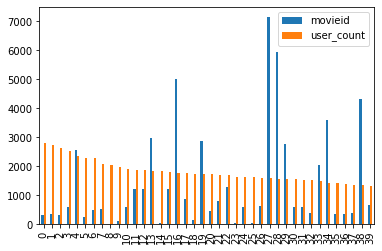

In [5]:
%matplotlib inline

ratings_agg.head(40).plot.bar()

# Подключение к Mongo

In [11]:
import os

from pymongo import MongoClient

In [12]:
mongo = MongoClient(**{
    'host': os.environ['APP_MONGO_HOST'],
    'port': int(os.environ['APP_MONGO_PORT'])
})
db = mongo["movie"]
collection = db['tags']

In [13]:
movies_with_tags = list({i['movie_id'] for i in collection.find({}, {'_id': 0, 'movie_id': 1})})
print(f"Количество фильмов с тэгами {len(movies_with_tags)}")

Количество фильмов с тэгами 42994


Трансформируем то, что достали из Mongo в DataFrame

In [14]:
def value2int(x):
    try:
        return int(x)
    except ValueError:
        return -1

movies_with_tags_df = pd.DataFrame({'movie_id': movies_with_tags})
movies_with_tags_df[
    'movie_id'
] = movies_with_tags_df[
    'movie_id'
].astype(
    dtype=np.uint32, errors = 'ignore'
).apply(value2int)

movies_with_tags_df.head(5)

,movie_id
0,110909
1,11795
2,18538
3,39839
4,176867


Отфильтровываем популярные фильмы, у которых отсутствуют тэги

In [17]:
ratings_agg_filtered = ratings_agg.merge(
    movies_with_tags_df,
    how='inner',
    left_on='movieid', right_on='movie_id'
)[['movieid', 'user_count']]

ratings_agg_filtered.head(3)

,movieid,user_count
0,110,1
1,147,1
2,858,1


Смотрим, какой жанр у самого популярного контента

In [18]:
most_popular_movie_id = ratings_agg.movieid.values[1]

doc = collection.find({'movie_id': f'{most_popular_movie_id}'}, {'_id': 0}).limit(1)
[i for i in doc]

[{'movie_id': '147', 'tag_id': 18, 'tag_name': 'Drama'}]

# Графика plotly

In [12]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)


In [28]:
ratings_agg_sorted = ratings_agg.sort_values(by='user_count', ascending=False).head(10)

trace = go.Bar(
    x = ratings_agg_sorted.movieid,
    y = ratings_agg_sorted.user_count
)
layout = go.Layout(
    title='Фильмы на IMDB',
)

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

## График популярности по времени

In [35]:
ratings_318 = ratings[ratings.movieid==318][['timestamp', 'userid']]
ratings_318.head(3)

,timestamp,userid
152,1486253595,7
210,1013444101,8
422,1231678204,11


In [39]:
from datetime import datetime

def unix_to_date(ts):
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d')

unix_to_date(1486253595)

'2017-02-05'

In [44]:
ratings_318 = ratings_318.assign(
    date=ratings_318.timestamp.apply(unix_to_date)
)

ratings_318.head(3)

,timestamp,userid,date
152,1486253595,7,2017-02-05
210,1013444101,8,2002-02-11
422,1231678204,11,2009-01-11


In [53]:
ratings_318_agg = ratings_318.groupby('date')['userid'].count().reset_index()
ratings_318_agg.head()

,date,userid
0,1996-03-02,1
1,1996-03-28,2
2,1996-03-29,1
3,1996-04-02,1
4,1996-04-05,4


In [60]:
trace = go.Line(
    x = ratings_318_agg.date,
    y = ratings_318_agg.userid
)
layout = go.Layout(
    title='Фильмы на IMDB',
)

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

In [59]:
import plotly.express as px

fig = px.scatter(ratings_318_agg, x="date", y="userid")
fig.show()